<a href="https://colab.research.google.com/github/Molzard/PCVK-Ganjil-2025/blob/main/Week14_Kelompok_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download dataset melalui kaggle**

In [ ]:
from google.colab import userdata
import os

try:
  os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
  os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
except Exception as e:
  print(e)

!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 99% 4.62G/4.66G [01:16<00:00, 80.2MB/s]
100% 4.66G/4.66G [01:16<00:00, 65.1MB/s]


# **Extract dataset**

In [ ]:
import zipfile
from tqdm import tqdm

zip_path = "fruits.zip"
extract_path = "fruits360"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())
    with tqdm(total=total_files, desc='Extracting') as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(file, extract_path)
            pbar.update(1)


Extracting: 100%|██████████| 286725/286725 [01:37<00:00, 2945.54it/s]


# **Proses Pra Pengolahan Data & Labeling**

## **Remapped Training**

In [1]:
import os
import shutil

# Mapping class (19)

class_map = {
    # Beetroot
    "Beetroot 1": "Beetroot_Red",

    # Cabbage
    "Cabbage red 1" : "Cabbage",
    "Cabbage white 1" : "Cabbage",

    # Carrot
    "Carrot 1" : "Carrot",

    # Cauliflower
    "Cauliflower 1" : "Cauliflower",

    # Ginger Root
    "Ginger Root 1" : "Ginger Root",

    # Kohlrabi
    "Kohlrabi 1" : "Kohlrabi",

    # Onion
    "Onion Red 1" : "Onion_Red",
    "Onion Red Peeled 1" : "Onion_Red",
    "Onion Red 2" : "Onion_Red",
    "Onion White 1" : "Onion_White",
    "Onion White Peeled 1" : "Onion_White",
    "Onion 2" : "Onion",

    # Potato
    "Potato Red 1" : "Potato_Red",
    "Potato Red Washed 1" : "Potato_Red",
    "Potato White 1" : "Potato_White",
    "Potato Sweet 1" : "Potato_Sweet",

    # Granadilla
    "Granadilla 1" : "Granadilla",

    # Maracuja
    "Maracuja 1" : "Maracuja",

    # Passion fruit
    "Passion Fruit 1" : "Passion_Fruit",

    # Plum
    "Plum 1" : "Plum_1",
    "Plum 2" : "Plum_2",
    "Plum 3" : "Plum_3",

    # Watermelon
    "Watermelon 1" : "Watermelon",
}

# Remap Test dataset

source_test = "/content/fruits360/fruits-360_100x100/fruits-360/Training"
target_test = "/content/Remapped_Training"

os.makedirs(target_test, exist_ok=True)

for original_class, new_class in class_map.items():

    src_dir = os.path.join(source_test, original_class)
    dst_dir = os.path.join(target_test, new_class)

    if not os.path.isdir(src_dir):
        print(f"[SKIP] Tidak ditemukan: {src_dir}")
        continue

    os.makedirs(dst_dir, exist_ok=True)

    for file in os.listdir(src_dir):
        src = os.path.join(src_dir, file)
        dst = os.path.join(dst_dir, f"{original_class}_{file}")
        shutil.copy2(src, dst)

print("Selesai! Remapped_Training berhasil dibuat.")

Selesai! Remapped_Training berhasil dibuat.


In [2]:
import os, json, shutil, cv2, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from sklearn.preprocessing import LabelEncoder

# Membuat labeling final yang disimpan ke file .json

DATASET_ROOT = "/content/Remapped_Training"
LABEL_PATH = "/content/label_final.json"

def build_label_json(root):
    data = []
    for cls in tqdm(os.listdir(root), desc="Scanning"):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path):
            continue
        for img in os.listdir(cls_path):
            if img.lower().endswith(('.png','.jpg','.jpeg')):
                data.append({
                    "path": os.path.join(cls_path, img),
                    "label": cls
                })
    with open(LABEL_PATH, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"label_final.json tersimpan: {len(data)} citra")

build_label_json(DATASET_ROOT)

Scanning: 100%|██████████| 19/19 [00:00<00:00, 386.77it/s]

label_final.json tersimpan: 11007 citra


In [3]:
# Validasi Konsisten Tabel

import collections
with open(LABEL_PATH) as f:
    records = json.load(f)

# Cek duplikasi path
paths = [r['path'] for r in records]
dup = [item for item, count in collections.Counter(paths).items() if count > 1]
if dup:
    print("Duplikasi path:", dup[:5])
else:
    print("Tidak ada duplikasi path")

# Cek label unik
labels = [r['label'] for r in records]
print("Label unik:", len(set(labels)), "kelas")
print("Distribusi per kelas:")
for k, v in collections.Counter(labels).items():
    print("  ", k, ":", v)

Tidak ada duplikasi path
Label unik: 19 kelas
Distribusi per kelas:
   Granadilla : 490
   Plum_3 : 900
   Kohlrabi : 471
   Maracuja : 490
   Onion_White : 748
   Cabbage : 293
   Plum_2 : 420
   Watermelon : 475
   Onion_Red : 1615
   Potato_Sweet : 450
   Carrot : 151
   Potato_White : 450
   Potato_Red : 903
   Beetroot_Red : 450
   Plum_1 : 447
   Passion_Fruit : 490
   Cauliflower : 702
   Ginger Root : 297
   Onion : 765


In [4]:
# Preprocessing Pipeline

PREPROCESSED_DIR = "/content/preprocessed"
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

def preprocess_image(img_path, target_size=(100,100)):
    """Return grayscale, normalized, resized"""
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Otomatis crop ROI (bounding box objek)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    x,y,w,h = cv2.boundingRect(th)
    crop = img[y:y+h, x:x+w]

    # Resize & normalize
    crop = cv2.resize(crop, target_size)
    crop = crop.astype("float32") / 255.0

    # Convert to grayscale (1 channel)
    gray_final = cv2.cvtColor((crop*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return gray_final/255.0   # keep 0-1

def run_preprocessing():
    le = LabelEncoder()
    le.fit(list(set(labels)))
    X, y = [], []
    for item in tqdm(records, desc="Preprocessing"):
        proc = preprocess_image(item['path'])
        if proc is None:
            continue
        cls_id = le.transform([item['label']])[0]

        # simpan ke disk (opsional)
        cls_dir = os.path.join(PREPROCESSED_DIR, item['label'])
        os.makedirs(cls_dir, exist_ok=True)
        fname = os.path.basename(item['path'])
        np.save(os.path.join(cls_dir, fname.split('.')[0]+'.npy'), proc)
        X.append(proc)
        y.append(cls_id)
    np.save("/content/X_processed.npy", np.array(X))
    np.save("/content/y_processed.npy", np.array(y))
    np.save("/content/classes.npy", le.classes_)
    print("Preprocessing selesai. Shape X:", np.array(X).shape)

run_preprocessing()

Preprocessing: 100%|██████████| 11007/11007 [00:15<00:00, 709.11it/s]


Preprocessing selesai. Shape X: (11007, 100, 100)


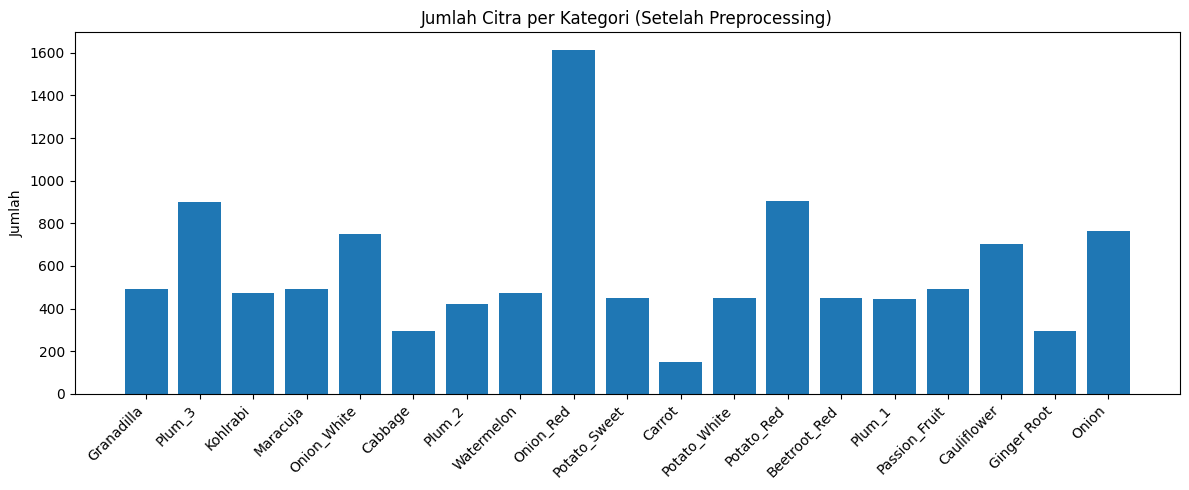

In [5]:
# Distribusi Label

plt.figure(figsize=(12,5))
plt.title("Jumlah Citra per Kategori (Setelah Preprocessing)")
cnt = collections.Counter([records[i]['label'] for i in range(len(records))])
plt.bar(cnt.keys(), cnt.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

In [6]:
print("=== LOG PREPROCESSING ===")
print(f"Total citra: {len(records)}")
print(f"Total kelas: {len(set(labels))}")
print("Ukuran akhir citra: 100×100 grayscale")
print(f"Folder preprocessed: {PREPROCESSED_DIR}")
print("File output:")
print("- label_final.json")
print("- X_processed.npy  (shape: {})".format(np.load("/content/X_processed.npy").shape))
print("- y_processed.npy")
print("- classes.npy (label encoder)")

=== LOG PREPROCESSING ===
Total citra: 11007
Total kelas: 19
Ukuran akhir citra: 100×100 grayscale
Folder preprocessed: /content/preprocessed
File output:
- label_final.json
- X_processed.npy  (shape: (11007, 100, 100))
- y_processed.npy
- classes.npy (label encoder)


In [7]:
# Split train test

from sklearn.model_selection import train_test_split
X = np.load("/content/X_processed.npy")
y = np.load("/content/y_processed.npy")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

np.save("/content/X_train.npy", X_train)
np.save("/content/X_test.npy", X_test)
np.save("/content/y_train.npy", y_train)
np.save("/content/y_test.npy", y_test)
print("Train-test split selesai")
print("  Train shape:", X_train.shape)
print("  Test shape :", X_test.shape)

Train-test split selesai
  Train shape: (8805, 100, 100)
  Test shape : (2202, 100, 100)


---


**<p align="center">Ekstraksi Fitur PCA (Reduksi Dimensi & Noise Removal)</p>**


---



In [8]:
import numpy as np, os, cv2, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from joblib import dump, load
from glob import glob
from tqdm import tqdm

# Load data preprocessed
X_train = np.load("/content/X_train.npy")
X_test  = np.load("/content/X_test.npy")
print("Loaded – train:", X_train.shape, "test:", X_test.shape)

Loaded – train: (8805, 100, 100) test: (2202, 100, 100)


In [9]:
# Flatten dan Standardize

# Flatten 2D → 1D
X_flat_train = X_train.reshape(len(X_train), -1)   # (N, 100*100)
X_flat_test  = X_test.reshape(len(X_test), -1)

# Standardisasi (mean=0, std=1)
mean = X_flat_train.mean(axis=0)
std  = X_flat_train.std(axis=0) + 1e-8            # aman bagi nol
X_flat_train = (X_flat_train - mean) / std
X_flat_test  = (X_flat_test  - mean) / std

# Simpan
np.save("/content/X_flat_train.npy", X_flat_train)
np.save("/content/X_flat_test.npy",  X_flat_test)
print("Flatten & standardize selesai")

Flatten & standardize selesai


In [10]:
# Train PCA

# Cari komponen optimal (contoh 40 → 92 % varian)
pca_full = PCA().fit(X_flat_train)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_comp = np.argmax(cumvar >= 0.92) + 1            # minimal 92 %
print(f"Komponen untuk 92 % varian: {n_comp}")

# Re-train PCA dengan n_comp
pca = PCA(n_components=n_comp, random_state=42)
pca.fit(X_flat_train)
dump(pca, "/content/model_pca.pkl")
print("model_pca.pkl tersimpan")

Komponen untuk 92 % varian: 224
model_pca.pkl tersimpan


In [11]:
# Transform & Simpan Fitur PCA

X_pca_train = pca.transform(X_flat_train)
X_pca_test  = pca.transform(X_flat_test)
np.save("/content/X_pca_train.npy", X_pca_train)
np.save("/content/X_pca_test.npy",  X_pca_test)
print("X_pca_train/test.npy tersimpan – shape:", X_pca_train.shape)

X_pca_train/test.npy tersimpan – shape: (8805, 224)


In [14]:
# Rekonstruksi Citra (low-noise) untuk input HOG

RECON_DIR = "/content/pca_reconstructed"
os.makedirs(RECON_DIR, exist_ok=True)

def save_reconstructed(X_p, split_name):
    """Simpan hasil rekonstruksi ke folder split_name/"""
    split_dir = os.path.join(RECON_DIR, split_name)
    os.makedirs(split_dir, exist_ok=True)
    X_rec = pca.inverse_transform(X_p)          # (N, 16384)
    X_rec = X_rec * std + mean                  # de-standardize
    X_rec = X_rec.clip(0,1).reshape(-1, 100,100)
    for i, img in enumerate(tqdm(X_rec, desc=f"Save {split_name}")):
        np.save(os.path.join(split_dir, f"{i:05d}.npy"), img)
    return X_rec

X_rec_train = save_reconstructed(X_pca_train, "train")
X_rec_test  = save_reconstructed(X_pca_test,  "test")
print("Folder pca_reconstructed/ selesai")

Save test: 100%|██████████| 2202/2202 [00:00<00:00, 3335.81it/s]

Folder pca_reconstructed/ selesai


In [15]:
print("=== LOG PCA ===")
print(f"Original dim   : {X_flat_train.shape[1]}")
print(f"PCA components : {n_comp}")
print(f"Varian tersimpan: {cumvar[n_comp-1]*100:.2f} %")
print(f"Reduksi dimensi : {X_flat_train.shape[1]} → {n_comp} ({100*(1-n_comp/X_flat_train.shape[1]):.1f}%)")
print("Output files:")
print("- X_flat_train/test.npy")
print("- model_pca.pkl")
print("- X_pca_train/test.npy")
print("- pca_reconstructed/train/*.npy")
print("- pca_reconstructed/test/*.npy")

=== LOG PCA ===
Original dim   : 10000
PCA components : 224
Varian tersimpan: 92.02 %
Reduksi dimensi : 10000 → 224 (97.8%)
Output files:
- X_flat_train/test.npy
- model_pca.pkl
- X_pca_train/test.npy
- pca_reconstructed/train/*.npy
- pca_reconstructed/test/*.npy


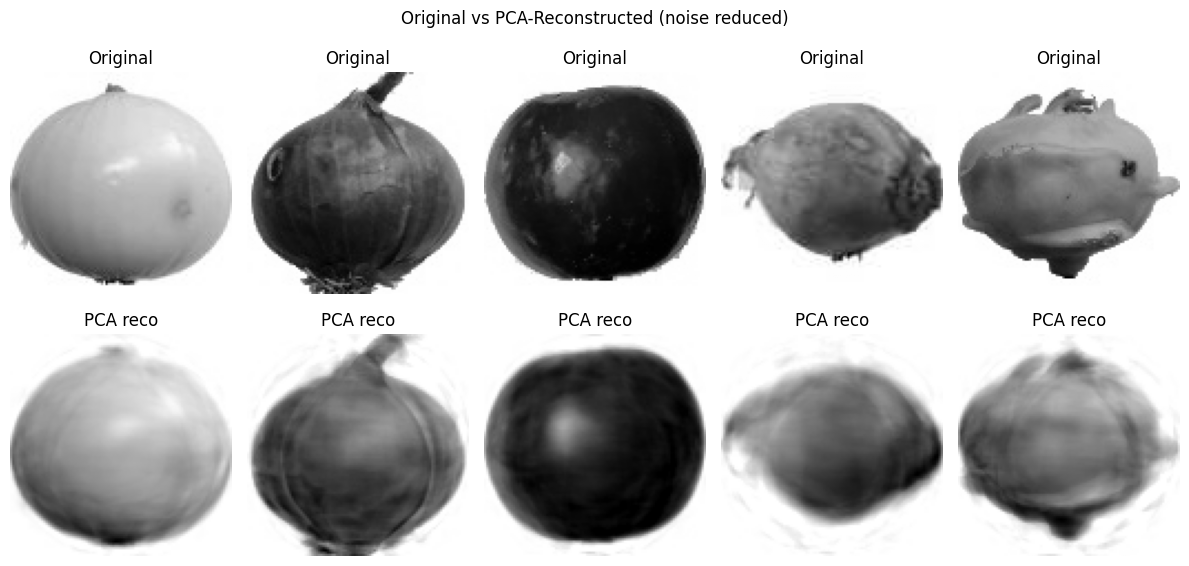

In [16]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title("Original"); plt.axis('off')
    plt.subplot(2,5,i+6)
    plt.imshow(X_rec_train[i], cmap='gray')
    plt.title("PCA reco"); plt.axis('off')
plt.suptitle("Original vs PCA-Reconstructed (noise reduced)")
plt.tight_layout()
plt.show()

---


**<p align="center">Ekstraksi Fitur HOG</p>**


---



In [18]:
import numpy as np, os, time, cv2
from skimage.feature import hog
from glob import glob
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Load citra PCA Rekonstruksi
TRAIN_DIR = "/content/pca_reconstructed/train"
TEST_DIR  = "/content/pca_reconstructed/test"

def load_folder(folder):
    paths = sorted(glob(os.path.join(folder, "*.npy")))
    imgs  = [np.load(p) for p in tqdm(paths, desc=f"Load {os.path.basename(folder)}")]
    return np.array(imgs)

X_rec_train = load_folder(TRAIN_DIR)
X_rec_test  = load_folder(TEST_DIR)
print("Loaded – train:", X_rec_train.shape, "test:", X_rec_test.shape)

Load test: 100%|██████████| 2202/2202 [00:00<00:00, 3852.69it/s]


Loaded – train: (8805, 100, 100) test: (2202, 100, 100)


In [19]:
#Copy soft supaya rapi

HOG_INPUT = "/content/hog_input"
os.makedirs(os.path.join(HOG_INPUT, "train"), exist_ok=True)
os.makedirs(os.path.join(HOG_INPUT, "test"),  exist_ok=True)

def copy_to_hog_input(X, split):
    for i, img in enumerate(tqdm(X, desc=f"Copy {split}")):
        np.save(os.path.join(HOG_INPUT, split, f"{i:05d}.npy"), img)
copy_to_hog_input(X_rec_train, "train")
copy_to_hog_input(X_rec_test,  "test")
print("hog_input/ siap")

Copy test: 100%|██████████| 2202/2202 [00:06<00:00, 355.91it/s]

hog_input/ siap


In [20]:
# Fungsi HOG Single Image

def compute_hog(img):
    """
    img: 2D numpy 0-1
    return: 1D HOG vector
    """
    fd = hog(img,
             orientations=9,
             pixels_per_cell=(8,8),
             cells_per_block=(2,2),
             block_norm='L2-Hys',
             transform_sqrt=True,
             feature_vector=True)
    return fd

In [21]:
# Batch Paraller HOG

def run_hog_parallel(X, split):
    t0 = time.time()
    feats = Parallel(n_jobs=-1, backend='threading')(
        delayed(compute_hog)(X[i]) for i in tqdm(range(len(X)), desc=f"HOG {split}")
    )
    feats = np.array(feats)
    elapsed = time.time() - t0
    return feats, elapsed

X_hog_train, time_train = run_hog_parallel(X_rec_train, "train")
X_hog_test,  time_test  = run_hog_parallel(X_rec_test,  "test")

print("HOG selesai – dimensi:", X_hog_train.shape[1])
print("   Waktu train: {:.2f}s  |  test: {:.2f}s".format(time_train, time_test))

HOG test: 100%|██████████| 2202/2202 [00:11<00:00, 193.88it/s]

HOG selesai – dimensi: 4356
   Waktu train: 55.21s  |  test: 11.40s


In [23]:
# Simpan fitur HOG

np.save("/content/X_hog_train.npy", X_hog_train)
np.save("/content/X_hog_test.npy",  X_hog_test)
print("X_hog_train/test.npy tersimpan")

X_hog_train/test.npy tersimpan


In [24]:
print("=== LOG HOG ===")
print(f"Input shape        : {X_rec_train.shape[1:]} (grayscale)")
print("Cell size          : 8×8")
print("Block size         : 2×2 cells")
print("Orientations       : 9")
print(f"Output dim         : {X_hog_train.shape[1]}")
print(f"Waktu eksekusi     : train {time_train:.2f}s | test {time_test:.2f}s")
print("Output files:")
print("- X_hog_train.npy")
print("- X_hog_test.npy")
print("- hog_input/")

=== LOG HOG ===
Input shape        : (100, 100) (grayscale)
Cell size          : 8×8
Block size         : 2×2 cells
Orientations       : 9
Output dim         : 4356
Waktu eksekusi     : train 55.21s | test 11.40s
Output files:
- X_hog_train.npy
- X_hog_test.npy
- hog_input/


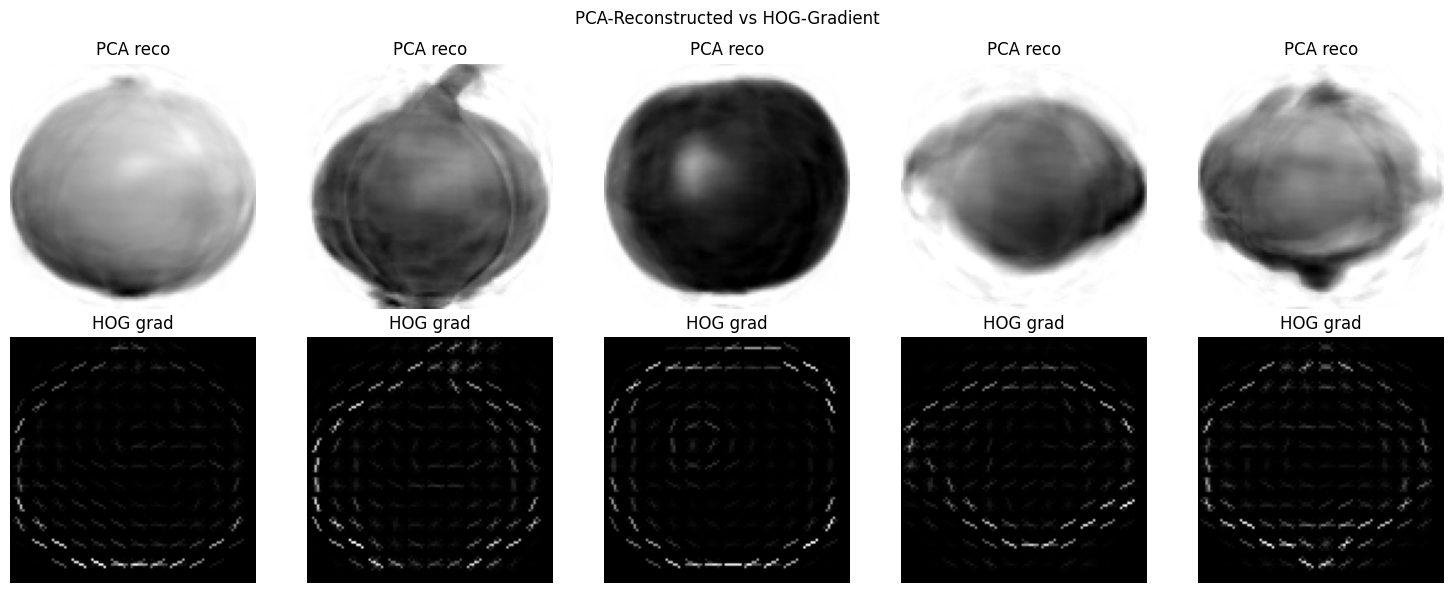

In [25]:
# Visualisasi 5 Contoh menggunakan HOG

from skimage import exposure

plt.figure(figsize=(15,6))
for i in range(5):
    img = X_rec_train[i]
    fd  = X_hog_train[i]
    hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                    cells_per_block=(2,2), visualize=True)[1]
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0,10))
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray'); plt.title("PCA reco"); plt.axis('off')
    plt.subplot(2,5,i+6)
    plt.imshow(hog_image, cmap='gray'); plt.title("HOG grad"); plt.axis('off')
plt.suptitle("PCA-Reconstructed vs HOG-Gradient")
plt.tight_layout()
plt.show()

---


**<p align="center">Ekstraksi Fitur GLCM (Tekstur Spasial)</p>**


---



In [26]:
import numpy as np, os, cv2
from skimage.feature import graycomatrix, graycoprops
from glob import glob
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd

# Load citra greyscale pada tahap sebelumnya (100×100, 0-1)
X_train = np.load("/content/X_processed.npy")   # sudah grayscale
X_test  = np.load("/content/X_test.npy")
print("Loaded – train:", X_train.shape, "test:", X_test.shape)

Loaded – train: (11007, 100, 100) test: (2202, 100, 100)


In [27]:
# Menyiapkan Folder GLCM Input (Kuantisasi 64 Level)

GLCM_INPUT = "/content/glcm_input"
os.makedirs(os.path.join(GLCM_INPUT, "train"), exist_ok=True)
os.makedirs(os.path.join(GLCM_INPUT, "test"),  exist_ok=True)

def quantize(img, levels=64):
    """Konversi 0-1 float → 0-levels-1 integer"""
    return (img * (levels-1)).astype(np.uint8)

def save_glcm_input(X, split):
    for i, img in enumerate(tqdm(X, desc=f"Save {split}")):
        q = quantize(img)
        np.save(os.path.join(GLCM_INPUT, split, f"{i:05d}.npy"), q)
save_glcm_input(X_train, "train")
save_glcm_input(X_test,  "test")
print("glcm_input/ siap (kuantisasi 64 level)")

Save test: 100%|██████████| 2202/2202 [00:00<00:00, 3253.53it/s]

glcm_input/ siap (kuantisasi 64 level)


In [28]:
# Fungsi GLCM Single Image

def compute_glcm(img):
    """
    img: 2D uint8 0-63
    return: rata2 4 fitur (contrast, correlation, energy, homogeneity)
    """
    # GLCM 4 orientasi, d=1, levels=64
    glcm = graycomatrix(img,
                        distances=[1],
                        angles=[0, 45, 90, 135],
                        levels=64,
                        symmetric=True,
                        normed=True)
    feats = []
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity']:
        vals = graycoprops(glcm, prop)
        feats.append(vals.mean())   # rata2 orientasi
    return np.array(feats)          # shape (4,)

In [29]:
# Batch Parallel GLCM

def run_glcm_parallel(X, split):
    X_q = [quantize(img) for img in X]   # kuantisasi
    feats = Parallel(n_jobs=-1, backend='threading')(
        delayed(compute_glcm)(X_q[i]) for i in tqdm(range(len(X)), desc=f"GLCM {split}")
    )
    return np.array(feats)

X_glcm_train = run_glcm_parallel(X_train, "train")
X_glcm_test  = run_glcm_parallel(X_test,  "test")
print("GLCM selesai – dimensi:", X_glcm_train.shape[1])

GLCM test: 100%|██████████| 2202/2202 [00:06<00:00, 342.66it/s]

GLCM selesai – dimensi: 4


In [30]:
# Menyimpan Fitur GLCM

np.save("/content/X_glcm_train.npy", X_glcm_train)
np.save("/content/X_glcm_test.npy",  X_glcm_test)
print("X_glcm_train/test.npy tersimpan")

X_glcm_train/test.npy tersimpan


In [33]:
# Validasi panjang masing-masing
print("X_glcm_train:", len(X_glcm_train))
print("y_train     :", len(y_train))
print()

# Samakan dengan memotong yang lebih pendek
n_min = min(len(X_glcm_train), len(y_train))
X_glcm_train = X_glcm_train[:n_min]
y_train      = y_train[:n_min]

# Log & Statistik Tekstur per kelas
df = pd.DataFrame(X_glcm_train, columns=['Contrast','Correlation','Energy','Homogeneity'])
df['Label'] = classes[y_train]
print()
print("=== Statistik GLCM per Kelas ===")
print(df.groupby('Label').agg(['mean','std','min','max']).round(3))
print("\n=== Rata-rata Fitur GLCM per Kelas ===")
print(df.groupby('Label').mean().round(3))

X_glcm_train: 8805
y_train     : 8805


=== Statistik GLCM per Kelas ===
              Contrast                       Correlation                       \
                  mean    std    min     max        mean    std    min    max   
Label                                                                           
Beetroot_Red    21.863  7.585  6.577  41.756       0.974  0.008  0.946  0.987   
Cabbage         21.121  7.087  6.503  39.521       0.974  0.007  0.947  0.987   
Carrot          21.266  7.180  6.503  42.375       0.973  0.007  0.951  0.986   
Cauliflower     21.244  7.491  6.585  42.005       0.974  0.007  0.947  0.987   
Ginger Root     21.259  7.695  6.578  41.661       0.974  0.007  0.947  0.986   
Granadilla      21.402  7.432  6.595  41.172       0.974  0.007  0.947  0.987   
Kohlrabi        20.744  7.591  6.454  41.462       0.974  0.007  0.946  0.986   
Maracuja        21.047  7.083  6.267  38.845       0.975  0.007  0.949  0.987   
Onion           21.954  7.509  6.289

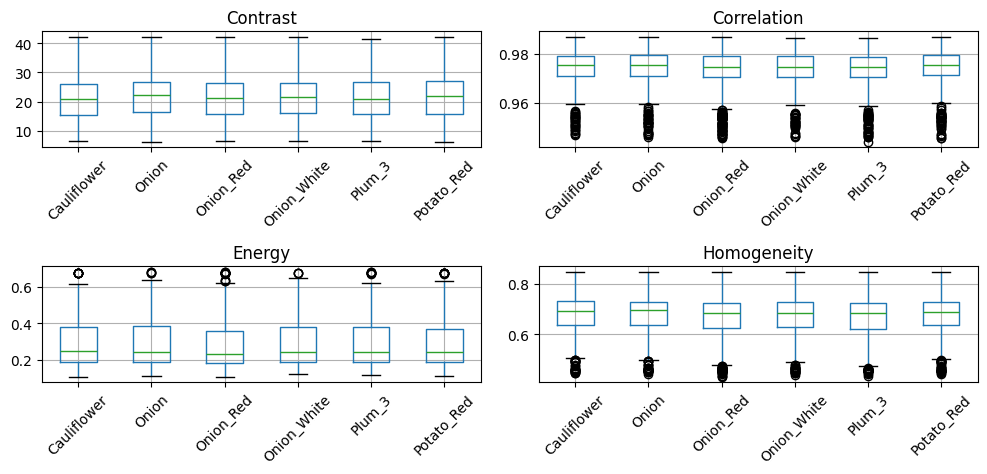

In [35]:
# Visualisasi Fitur

# Mengambil kelas dgn jumlah citra paling banyak
top_labels = df['Label'].value_counts().head(6).index   # 6 kelas index
df_top = df[df['Label'].isin(top_labels)]

plt.figure(figsize=(10,5))
for i, col in enumerate(['Contrast','Correlation','Energy','Homogeneity']):
    plt.subplot(2,2,i+1)
    df_top.boxplot(column=col, by='Label', ax=plt.gca(), rot=45)
    plt.title(col)
    plt.suptitle('')
    plt.xlabel('')
plt.tight_layout()
plt.show()

---


**<p align="center">Penggabungan Fitur Multi-Level (PCA + HOG + GLCM)</p>**


---



In [36]:
import numpy as np, os
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# Load semua fitur
X_pca_train = np.load("/content/X_pca_train.npy")
X_pca_test  = np.load("/content/X_pca_test.npy")

X_hog_train = np.load("/content/X_hog_train.npy")
X_hog_test  = np.load("/content/X_hog_test.npy")

X_glcm_train = np.load("/content/X_glcm_train.npy")
X_glcm_test  = np.load("/content/X_glcm_test.npy")

print("Loaded shapes:")
print("PCA :", X_pca_train.shape[1])
print("HOG :", X_hog_train.shape[1])
print("GLCM:", X_glcm_train.shape[1])

Loaded shapes:
PCA : 224
HOG : 4356
GLCM: 4


In [37]:
# Gabungan Horizontal (PCA + HOG)
X_ph_train = np.hstack([X_pca_train, X_hog_train])
X_ph_test  = np.hstack([X_pca_test,  X_hog_test])
print("PCA+HOG – dim:", X_ph_train.shape[1])

PCA+HOG – dim: 4580


In [39]:
# Mengecek panjang dimensi dari PCA dan HOG
print("PCA/HOG train:", X_ph_train.shape[0])
print("GLCM train   :", X_glcm_train.shape[0])

# Menyamakan jumlah sampel GLCM dengan sampel PCA/HOG
n_min = min(X_ph_train.shape[0], X_glcm_train.shape[0])
X_ph_train = X_ph_train[:n_min]
X_glcm_train = X_glcm_train[:n_min]

n_min_te = min(X_ph_test.shape[0], X_glcm_test.shape[0])
X_ph_test  = X_ph_test[:n_min_te]
X_glcm_test = X_glcm_test[:n_min_te]

# Menambahkan GLCM sebagai final fitur
X_raw_train = np.hstack([X_ph_train, X_glcm_train])
X_raw_test  = np.hstack([X_ph_test,  X_glcm_test])
print("PCA+HOG+GLCM – dim:", X_raw_train.shape[1], "| sampel:", X_raw_train.shape[0])

PCA/HOG train: 8805
GLCM train   : 11007
PCA+HOG+GLCM – dim: 4584 | sampel: 8805


In [40]:
# Normalisasi Akhir (StandardScaler)
scaler = StandardScaler()
X_final_train = scaler.fit_transform(X_raw_train)
X_final_test  = scaler.transform(X_raw_test)

np.save("/content/X_final_train.npy", X_final_train)
np.save("/content/X_final_test.npy",  X_final_test)
print("X_final_train/test.npy tersimpan")

X_final_train/test.npy tersimpan


In [42]:
# Menyimpan Pipeline Extractor
extractor = {
    'scaler': scaler,
    'dim_pca': X_pca_train.shape[1],
    'dim_hog': X_hog_train.shape[1],
    'dim_glcm': X_glcm_train.shape[1],
    'total_dim': X_final_train.shape[1]
}
dump(extractor, "/content/extractor_fusion.pkl")
print("extractor_fusion.pkl tersimpan")

extractor_fusion.pkl tersimpan


In [43]:
# Validasi Akhir
def validate(X_tr, X_te):
    assert np.isnan(X_tr).sum() == 0, "Missing value di train"
    assert np.isnan(X_te).sum() == 0, "Missing value di test"
    assert X_tr.shape[1] == X_te.shape[1], "Dimensi tidak sama"
    print("Tidak ada missing value")
    print("Fitur ter-scale (mean≈0, std≈1)")
    print("Dimensi seragam:", X_tr.shape[1])

validate(X_final_train, X_final_test)

Tidak ada missing value
Fitur ter-scale (mean≈0, std≈1)
Dimensi seragam: 4584


In [44]:
# Log Final
print("=== LOG FUSION PCA+HOG+GLCM ===")
print(f"PCA dim   : {extractor['dim_pca']}")
print(f"HOG dim   : {extractor['dim_hog']}")
print(f"GLCM dim  : {extractor['dim_glcm']}")
print(f"Total dim : {extractor['total_dim']}")
print("Output:")
print("- X_final_train.npy")
print("- X_final_test.npy")
print("- extractor_fusion.pkl")

=== LOG FUSION PCA+HOG+GLCM ===
PCA dim   : 224
HOG dim   : 4356
GLCM dim  : 4
Total dim : 4584
Output:
- X_final_train.npy
- X_final_test.npy
- extractor_fusion.pkl
